In [1]:
import sys
import os

print("Current Working Directory:", os.getcwd())

# Add the examples directory to sys.path so we can import the set_random_seed function and other utilities from causal_helpers
examples_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'examples'))
sys.path.append(examples_dir)
# Now import set_random_seed directly from causal_helpers
from causal_helpers import set_random_seed
from cyclic_obs_data_generator import sample_er_dcg, sample_sf_dcg, sample_nws_dcg
from cyclic_obs_data_generator import sample_W, sample_data

# Add the data directory to sys.path so we can save and load data files
data_dir = os.path.abspath(os.path.join(examples_dir, '..', 'data'))

# Use the function
#seed = 41 # main seed
seed = 22
set_random_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Current Working Directory:", os.getcwd())

Current Working Directory: /home/amine.mcharrak/pcax/examples
Current Working Directory: /home/amine.mcharrak/pcax/examples


In [2]:
# Example usage
num_samples = 5000
#n_vars = 10
n_vars = 8
max_degree = int(n_vars // 2)
max_cycle = 4

# Generate data
B = sample_er_dcg(n_vars=n_vars, max_degree=max_degree, max_cycle=max_cycle)
#B = sample_sf_dcg(n_vars=n_vars, max_degree=max_degree, max_cycle=max_cycle)
#B = sample_nws_dcg(n_vars=n_vars, max_degree=max_degree, max_cycle=max_cycle)
print("B created")

#W, noise_scales = sample_W(B)
W, _ = sample_W(B)
print("W created")

#X = sample_data(B=B, noise_scales=noise_scales, num_samples=num_samples) # noise from uniform distribution**5
#X = sample_data(B=B, noise_scales=None, num_samples=num_samples, softplus=True) # noise from softplus(normal(0,1))
scales = np.ones(n_vars, dtype=float)

#X, prec_matrix = sample_data(W=W, scales=scales, num_samples=num_samples, noise_type='exp')
#X, prec_matrix = sample_data(W=W, scales=scales, num_samples=num_samples, noise_type='gauss-ev')
X, prec_matrix = sample_data(W=W, scales=scales, num_samples=num_samples, noise_type='softplus')
print("X created")

data = pd.DataFrame(X, columns=[f"X{i}" for i in range(n_vars)])

# Display the adjacency matrix and a preview of the data
print("Adjacency Matrix:")
print(B)
print("\nGenerated Data:")
print(data.head())
print("\nTrue Weights:")
print(W)

B created
W created
X created
Adjacency Matrix:
[[0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 1. 0.]]

Generated Data:
         X0        X1        X2        X3        X4        X5        X6  \
0  1.038968  3.231990 -2.628052  4.703457 -3.603513  1.976863  0.632172   
1  1.124824  1.309004 -2.683948  2.167785 -0.947117 -0.711598 -0.772552   
2  0.113995  0.850336 -2.495052  2.068714 -1.527810 -0.098714  0.215241   
3  0.361664  2.377071 -0.282051  1.797503 -0.534448  1.591814  0.113173   
4  1.340929  3.501848 -1.532260  2.502640 -1.658266  0.739261 -0.483347   

         X7  
0 -1.955949  
1  0.638985  
2  0.640822  
3 -1.185849  
4 -1.356674  

True Weights:
[[-0.          0.61483684 -0.64623055  0.90257769 -0.78071153  0.
  -0.          0.        ]
 [ 0.         -0.         -0.         -0.         -0.         -0.
  -0.6106

In [3]:
data.describe()

,X0,X1,X2,X3,X4,X5,X6,X7
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.819686,2.714852,-1.171304,2.334880,-1.475774,1.404266,-0.015681,-1.011258
std,0.531586,1.735266,1.705619,1.459492,1.603946,1.503455,0.591737,1.502378
min,0.026295,-4.172161,-9.243436,-3.574543,-8.898012,-4.740926,-2.264373,-7.778522
25%,0.413138,1.600125,-2.206680,1.423427,-2.504712,0.453159,-0.394747,-2.009370
50%,0.706609,2.683199,-1.009952,2.329711,-1.476274,1.406152,-0.053209,-1.132635
75%,1.102576,3.811774,0.006315,3.281237,-0.465928,2.357826,0.328285,-0.119121
max,3.706263,12.082518,3.993507,8.407167,4.589359,8.442042,3.002023,6.272451


In [4]:
is_cont = np.array([True if data[col].nunique() > 2 else False for col in data.columns])
is_cont.shape
print(is_cont.tolist())

[True, True, True, True, True, True, True, True]


In [5]:
import networkx as nx

G = nx.DiGraph(B)

print("Is the graph directed?", G.is_directed())

is_cyclic = False  # Initialize is_cyclic to False
try:
    cycles = nx.find_cycle(G)
    is_cyclic = True  # Set to True if a cycle is found
    print("Is the graph cyclic?", is_cyclic)
    print(f"There are {len(list(nx.simple_cycles(G)))} cycles in the graph, including: {cycles} for example.")
except nx.NetworkXNoCycle:
    print("Is the graph cyclic?", is_cyclic)  # Use the boolean variable directly

print(f"Number of edges: {G.number_of_edges()}")
print(f"Number of nodes: {G.number_of_nodes()}")

Is the graph directed? True
Is the graph cyclic? True
There are 3 cycles in the graph, including: [(1, 6), (6, 5), (5, 1)] for example.
Number of edges: 16
Number of nodes: 8


In [6]:
#noise_type = "softplus"
#noise_type = "exp"
#noise_type = "gauss-ev"
noise_type = "softplus"

#graph_type = "sf"
graph_type = "er"
#graph_type = "nws"

dir_name = os.path.join(data_dir, "linear_cyclic_" + noise_type + "_" + graph_type + "_nvars_" + str(n_vars) + "_n_samples_" + str(num_samples))
#dir_name = os.path.join(data_dir, "linear_cyclic_uniform")

os.makedirs(dir_name, exist_ok=True)

# store the adjacency matrix as a csv file named "adj_matrix.csv" without header
adj_matrix_df = pd.DataFrame(B)
adj_matrix_df.to_csv(f"{dir_name}/adj_matrix.csv", header=False, index=False)

# store the data as a csv file named "train.csv" without header
data.to_csv(f"{dir_name}/train.csv", header=False, index=False)

# store the weighted adjacency matrix as a csv file named "W.csv" without header
W_df = pd.DataFrame(W)
W_df.to_csv(f"{dir_name}/W_adj_matrix.csv", header=False, index=False)

# store the precision matrix as a csv file named "prec_matrix.csv" without header
if prec_matrix is not None:
    prec_matrix_df = pd.DataFrame(prec_matrix)
    prec_matrix_df.to_csv(f"{dir_name}/prec_matrix.csv", header=False, index=False)

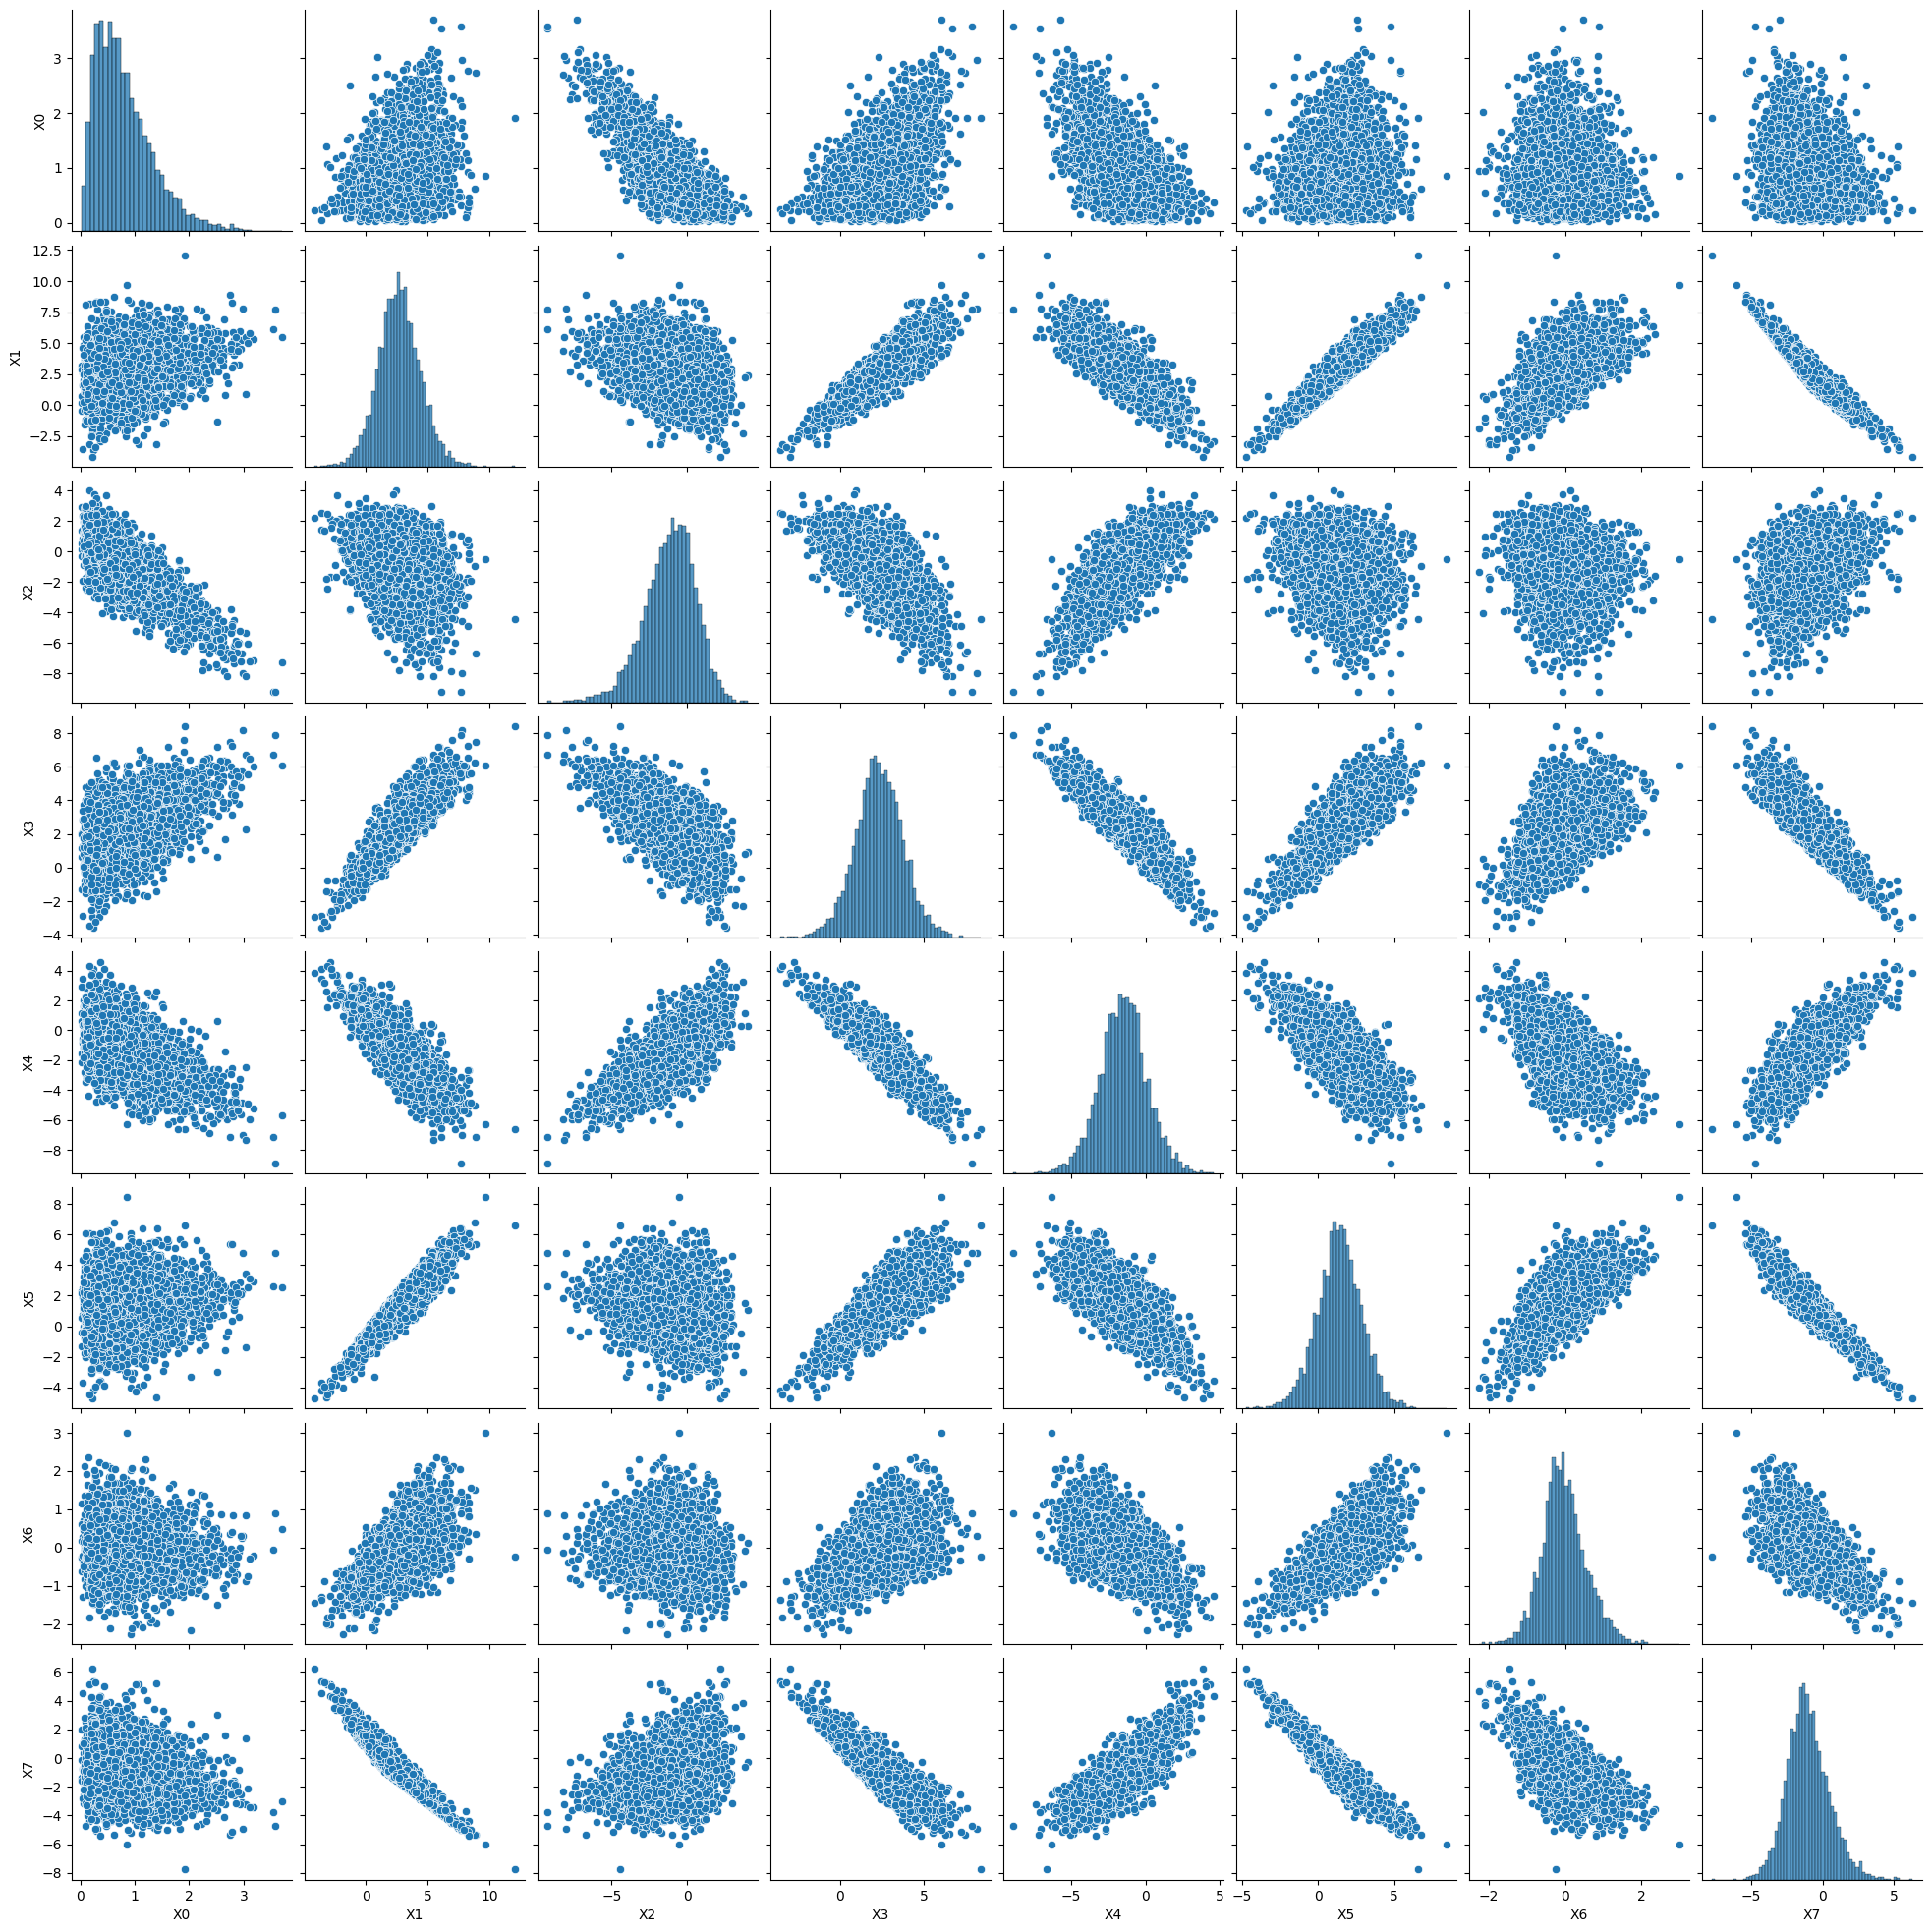

In [7]:
# plot the distribution of all variables against each other and save the plot as "pairplot.pdf"
import seaborn as sns
sns.pairplot(data)
plt.savefig(f"{dir_name}/pairplot.pdf")

In [8]:
################################## MISC ##################################

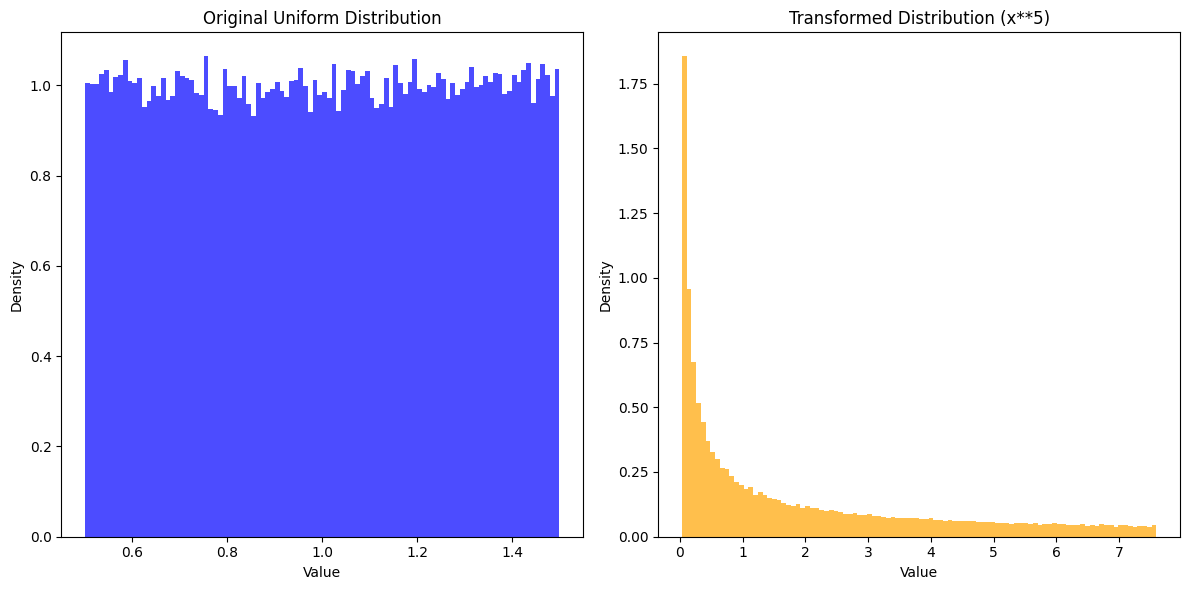

In [9]:
# Parameters for the uniform distribution
low, high = -1, 1  # Range of the uniform distribution
size = 100000  # Number of samples

# Generate uniform samples
uniform_samples = np.random.uniform(0.5, 1.5, size)

# Apply the power transformation
power = 5
transformed_samples = uniform_samples**power

# Plot the original and transformed distributions
plt.figure(figsize=(12, 6))

# Original uniform distribution
plt.subplot(1, 2, 1)
plt.hist(uniform_samples, bins=100, density=True, alpha=0.7, color='blue')
plt.title("Original Uniform Distribution")
plt.xlabel("Value")
plt.ylabel("Density")

# Transformed distribution
plt.subplot(1, 2, 2)
plt.hist(transformed_samples, bins=100, density=True, alpha=0.7, color='orange')
plt.title(f"Transformed Distribution (x**{power})")
plt.xlabel("Value")
plt.ylabel("Density")

plt.tight_layout()
plt.show()


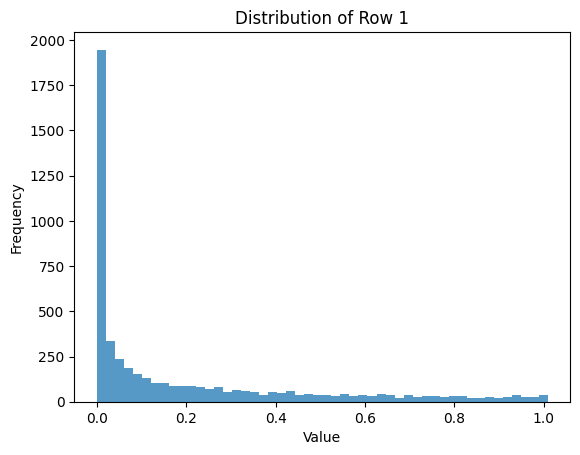

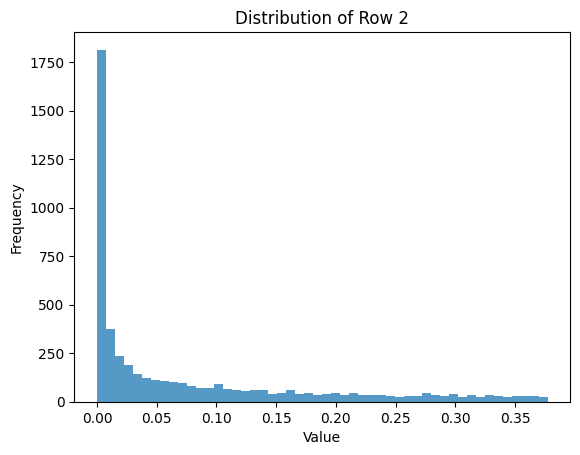

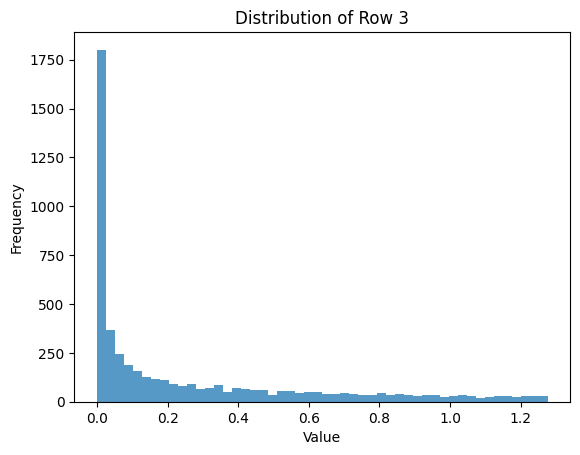

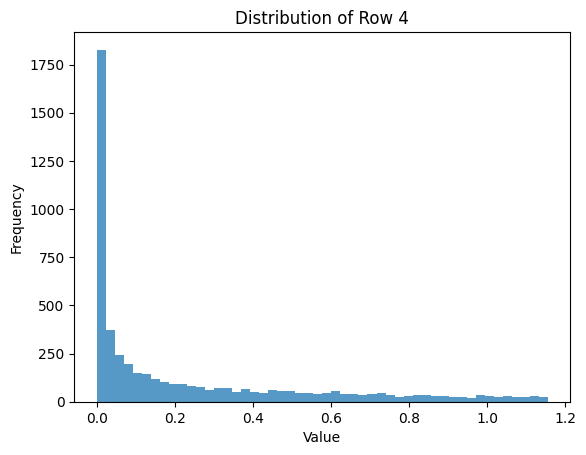

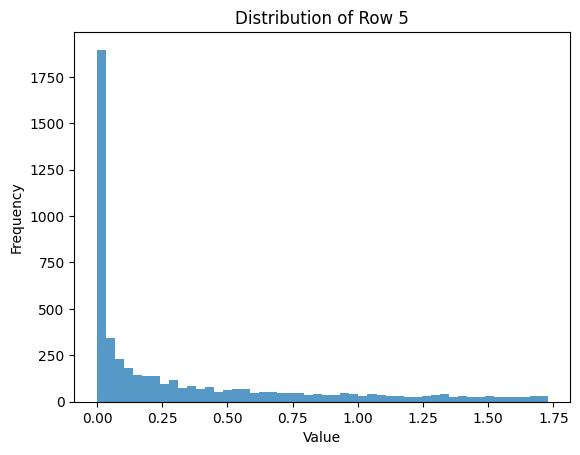

In [10]:
n_var = 5
noise_scales = np.random.uniform(0.5, 1.5, size=n_var)
noise = (np.random.uniform(-np.array(noise_scales).reshape(-1, 1), np.array(noise_scales).reshape(-1, 1), size=(n_var, 5000)).T)**4

# Plot histograms for each row
for i in range(n_var):
    plt.figure()
    plt.hist(noise[:, i], bins=50, alpha=0.75)
    plt.title(f'Distribution of Row {i+1}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

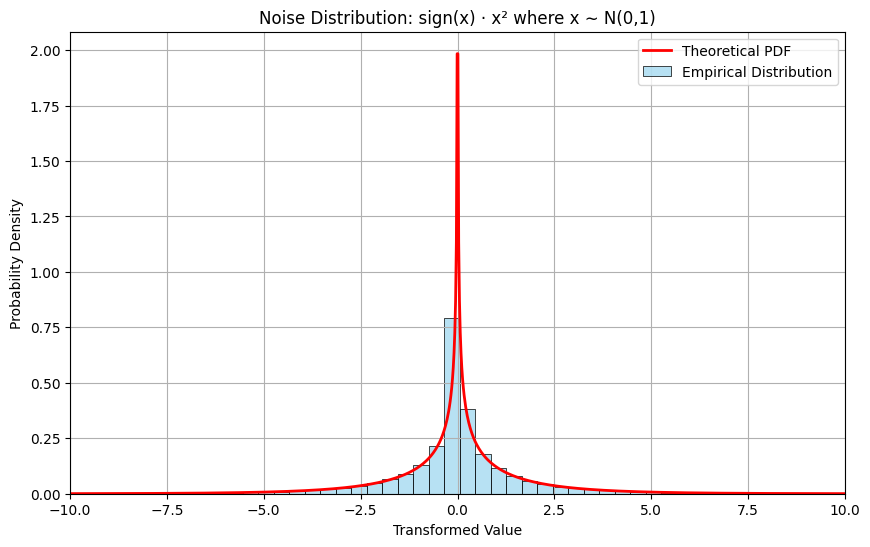

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate samples from transformed Gaussian distribution
np.random.seed(42)
x = np.random.normal(0, 1, 100000)  # Original Gaussian samples
y = np.sign(x) * (x ** 2)          # Apply transformation

# Theoretical PDF calculation
def theoretical_pdf(y):
    with np.errstate(divide='ignore', invalid='ignore'):
        pdf = 1 / (2 * np.sqrt(2 * np.pi * np.abs(y))) * np.exp(-np.abs(y)/2)
    return np.nan_to_num(pdf)

# Create visualization
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=100, stat='density', alpha=0.6, color='skyblue', label='Empirical Distribution')

# Plot theoretical distribution
x_range = np.linspace(-10, 10, 1000)
plt.plot(x_range, theoretical_pdf(x_range), 'r-', lw=2, label='Theoretical PDF')

plt.title('Noise Distribution: sign(x) · x² where x ∼ N(0,1)')
plt.xlabel('Transformed Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.xlim(-10, 10)  # Focus on central region
plt.show()